# Shakespeare Deep Learning

## Importing libraries and dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import re



In [2]:
data = open("shakespeare.txt").read()
data[:500]

"THE SONNETS\n\nby William Shakespeare\n\nFrom fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light's flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:\nThou that art now the world's fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest"

## WordCloud

In [3]:
wordcloud = WordCloud(max_font_size=70, max_words=200,
                   background_color="white").generate(data)

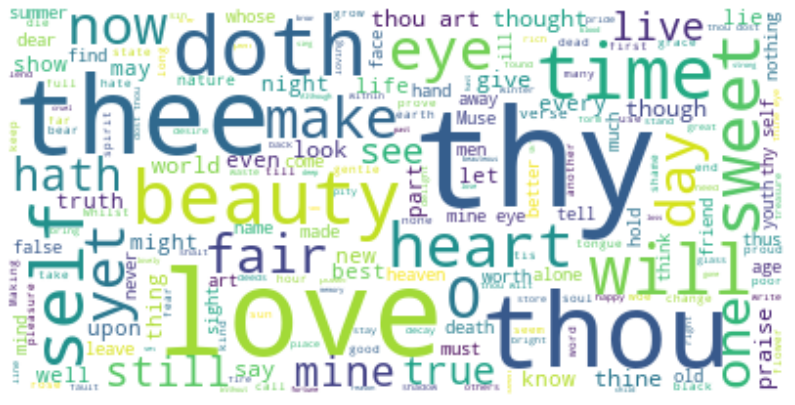

In [4]:
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize = (14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("poemcloud.png")
plt.show()

## Investigating the corpus

In [5]:
corpus = data.lower().split("\n")
corpus

['the sonnets',
 '',
 'by william shakespeare',
 '',
 'from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou contracted to thine own bright eyes,',
 "feed'st thy light's flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thy self thy foe, to thy sweet self too cruel:',
 "thou that art now the world's fresh ornament,",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content,',
 "and tender churl mak'st waste in niggarding:",
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 '',
 'when forty winters shall besiege thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery so gazed on now,",
 'will be a tattered weed of small worth held:  ',
 'then being asked, where all thy beauty lies,',
 'where all the treasure of thy lu

## Removing characters

In [7]:
type(corpus)
corpus = [re.compile(r"by william shakespeare").sub("", m) for m in corpus]
corpus = [re.compile(r"the sonnets").sub("", m) for m in corpus]
corpus

['',
 '',
 '',
 '',
 'from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou contracted to thine own bright eyes,',
 "feed'st thy light's flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thy self thy foe, to thy sweet self too cruel:',
 "thou that art now the world's fresh ornament,",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content,',
 "and tender churl mak'st waste in niggarding:",
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 '',
 'when forty winters shall besiege thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery so gazed on now,",
 'will be a tattered weed of small worth held:  ',
 'then being asked, where all thy beauty lies,',
 'where all the treasure of thy lusty days;',
 'to say within thine

In [10]:
length = []
for line in corpus:
    length.append(len(line))
pd.Series(length).describe()

count    2469.000000
mean       37.170514
std        14.674027
min         0.000000
25%        38.000000
50%        42.000000
75%        45.000000
max        59.000000
dtype: float64

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)

print(total_words)

3197


## Creating train and target

In [12]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

train, target = input_sequences[:,:-1],input_sequences[:,-1]
target = ku.to_categorical(target, num_classes=total_words+1)

In [13]:
model = Sequential()
model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           319800    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3197)              322897    
_________________________________________________________________
dense_1 (Dense)              (None, 3198)              10227204  
Total params: 11,331,501
Trainable params: 11,331,501
Non-trainable params: 0
____________________________________________

In [14]:
history = model.fit(train, target, epochs=160, verbose=1)

Epoch 1/160
485/485 [==============================] - 33s 68ms/step - loss: 6.8543 - accuracy: 0.0222
Epoch 2/160
485/485 [==============================] - 33s 67ms/step - loss: 6.4842 - accuracy: 0.0215
Epoch 3/160
485/485 [==============================] - 33s 69ms/step - loss: 6.3662 - accuracy: 0.0257
Epoch 4/160
485/485 [==============================] - 33s 69ms/step - loss: 6.2456 - accuracy: 0.0315
Epoch 5/160
485/485 [==============================] - 33s 69ms/step - loss: 6.1551 - accuracy: 0.0355
Epoch 6/160
485/485 [==============================] - 33s 69ms/step - loss: 6.0699 - accuracy: 0.0398
Epoch 7/160
485/485 [==============================] - 34s 69ms/step - loss: 5.9854 - accuracy: 0.0421
Epoch 8/160
485/485 [==============================] - 33s 69ms/step - loss: 5.8916 - accuracy: 0.0458
Epoch 9/160
485/485 [==============================] - 34s 69ms/step - loss: 5.7821 - accuracy: 0.0521
Epoch 10/160
485/485 [==============================] - 34s 70ms/step - l

485/485 [==============================] - 32s 67ms/step - loss: 1.3107 - accuracy: 0.7693
Epoch 80/160
485/485 [==============================] - 33s 68ms/step - loss: 1.2928 - accuracy: 0.7731
Epoch 81/160
485/485 [==============================] - 33s 68ms/step - loss: 1.2800 - accuracy: 0.7777
Epoch 82/160
485/485 [==============================] - 33s 69ms/step - loss: 1.2694 - accuracy: 0.7767
Epoch 83/160
485/485 [==============================] - 33s 68ms/step - loss: 1.2553 - accuracy: 0.7813
Epoch 84/160
485/485 [==============================] - 32s 66ms/step - loss: 1.2355 - accuracy: 0.7854
Epoch 85/160
485/485 [==============================] - 32s 66ms/step - loss: 1.2308 - accuracy: 0.7878
Epoch 86/160
485/485 [==============================] - 32s 66ms/step - loss: 1.2369 - accuracy: 0.7830
Epoch 87/160
485/485 [==============================] - 32s 66ms/step - loss: 1.2115 - accuracy: 0.7886
Epoch 88/160
485/485 [==============================] - 32s 66ms/step - loss:

485/485 [==============================] - 33s 68ms/step - loss: 0.8540 - accuracy: 0.8326
Epoch 158/160
485/485 [==============================] - 33s 68ms/step - loss: 0.8447 - accuracy: 0.8354
Epoch 159/160
485/485 [==============================] - 33s 69ms/step - loss: 0.8462 - accuracy: 0.8340
Epoch 160/160
485/485 [==============================] - 38s 78ms/step - loss: 0.8414 - accuracy: 0.8314


## Plotting results

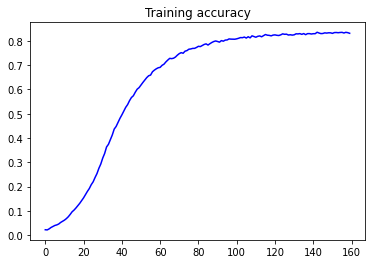

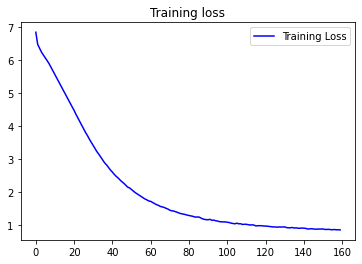

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Saving the model

In [17]:
import os

In [18]:
root_path = os.path.dirname(os.getcwd())
path = os.path.join(root_path,'new_model','nn_model')
path

'/Users/nicolo/Desktop/projects/new_model/nn_model'

In [19]:
model.save(path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/nicolo/Desktop/projects/new_model/nn_model/assets


In [18]:
from tensorflow import keras

keras.models.load_model(path)

In [19]:
model2 = keras.models.load_model(path)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           320100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3200)              323200    
_________________________________________________________________
dense_1 (Dense)              (None, 3201)              10246401  
Total params: 11,351,301
Trainable params: 11,351,301
Non-trainable params: 0
____________________________________________

# Attempting text generator

In [22]:
seed_text = "Oh tho lovely creature"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Oh tho lovely creature the level of your frown committed knit things near glory ere thee not was thee strong much wantonness wantonness brow green each faults with woe fire eyes live before so lie with a night alone new fears so long alone doth write no truth alone still come may seem fair fled confounds him decay keep behind such near prove me live as good end lie with thee alone so press no part one seen so sort hate fled live live was ' live more lies there doth other more more delight than lie hid to speed see lie must be


In [24]:
seed_text = "I love you, but"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I love you, but for you shall have no hate lose loving rolling show thee live hate was should see thee knows ere such bring thee of life blushing woe brow staineth sit shown twain shown near find me admiring woe eye's prove thee acquainted seem part new still keep behind so part one ' say to thee as much lie with me now new doth go new doth new must still appear thee so alone are nothing die best alone before his hate taken taken taken taken shown taken brought must afford stand hate affords live bearing thee more survey lies sit sit
